# Book Recommendation System using Matrix Factorization

This notebook implements a recommendation system using SVD (Singular Value Decomposition) with GridSearchCV for parameter tuning.

In [2]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD
from surprise.model_selection import GridSearchCV, cross_validate
from surprise.dataset import DatasetAutoFolds
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
# plt.style.use('seaborn')
sns.set_palette('husl')

## 1. Load and Prepare Data

In [3]:
def load_data():
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')
    
    print("Train data shape:", train_df.shape)
    print("Test data shape:", test_df.shape)
    
    # Create a reader object
    reader = Reader(rating_scale=(1, 5))
    
    # Create the trainset
    train_data = Dataset.load_from_df(train_df[['user_id', 'book_id', 'rating']], reader)
    
    return train_data, test_df, train_df

# Load the data
train_data, test_df, train_df = load_data()

Train data shape: (100523, 3)
Test data shape: (29367, 3)


## 2. Analyze Training Data Distribution

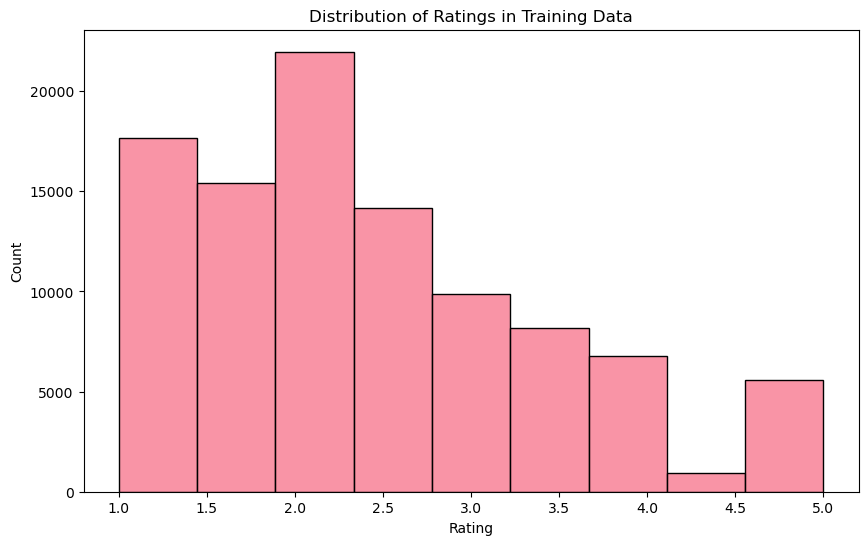


Rating Statistics:
count    100523.000000
mean          2.361738
std           1.106863
min           1.000000
25%           1.500000
50%           2.000000
75%           3.000000
max           5.000000
Name: rating, dtype: float64


In [4]:
def plot_rating_distribution(train_df):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=train_df, x='rating', bins=9)
    plt.title('Distribution of Ratings in Training Data')
    plt.xlabel('Rating')
    plt.ylabel('Count')
    plt.show()
    
    # Print rating statistics
    print("\nRating Statistics:")
    print(train_df['rating'].describe())

plot_rating_distribution(train_df)

## 3. Parameter Tuning with GridSearchCV

Best RMSE score: 0.9127390700917682
Best parameters: {'n_epochs': 40, 'lr_all': 0.01, 'reg_all': 0.1}


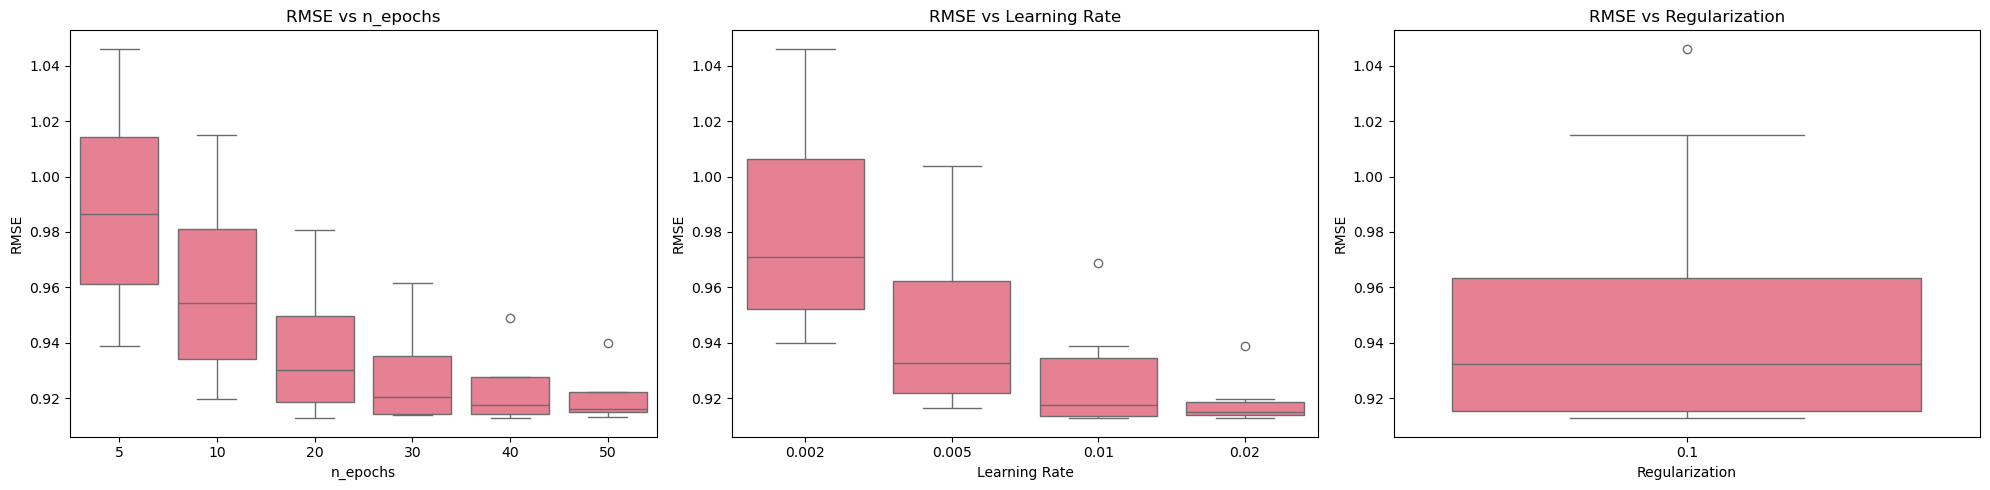

In [12]:
def tune_svd_params(train_data):
    # Define the parameter grid
    param_grid = {
        'n_epochs': [5, 10, 20, 30, 40, 50],
        'lr_all': [0.002, 0.005, 0.01, 0.02],
        'reg_all': [0.1]
    }
    
    # Initialize GridSearch
    gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
    
    # Fit GridSearch
    gs.fit(train_data)
    
    # Best parameters
    print("Best RMSE score:", gs.best_score['rmse'])
    print("Best parameters:", gs.best_params['rmse'])
    
    # Plot parameter comparison
    plot_parameter_comparison(gs)
    
    return gs.best_params['rmse']

def plot_parameter_comparison(gs):
    # Extract results for each parameter
    results_df = pd.DataFrame(gs.cv_results)
    
    # Create subplots for each parameter
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    
    # Plot for n_epochs
    sns.boxplot(data=results_df, x='param_n_epochs', y='mean_test_rmse', ax=axes[0])
    axes[0].set_title('RMSE vs n_epochs')
    axes[0].set_xlabel('n_epochs')
    axes[0].set_ylabel('RMSE')
    
    # Plot for lr_all
    sns.boxplot(data=results_df, x='param_lr_all', y='mean_test_rmse', ax=axes[1])
    axes[1].set_title('RMSE vs Learning Rate')
    axes[1].set_xlabel('Learning Rate')
    axes[1].set_ylabel('RMSE')
    
    # Plot for reg_all
    sns.boxplot(data=results_df, x='param_reg_all', y='mean_test_rmse', ax=axes[2])
    axes[2].set_title('RMSE vs Regularization')
    axes[2].set_xlabel('Regularization')
    axes[2].set_ylabel('RMSE')
    
    plt.tight_layout()
    plt.show()

# Tune parameters
best_params = tune_svd_params(train_data)

## 4. Train Model with Best Parameters

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9042  0.8965  0.9005  0.9080  0.9001  0.9019  0.0039  
MAE (testset)     0.6913  0.6912  0.6918  0.6951  0.6915  0.6922  0.0015  
Fit time          3.05    2.65    2.65    2.13    2.08    2.51    0.36    
Test time         0.15    0.15    0.12    0.12    0.13    0.13    0.01    


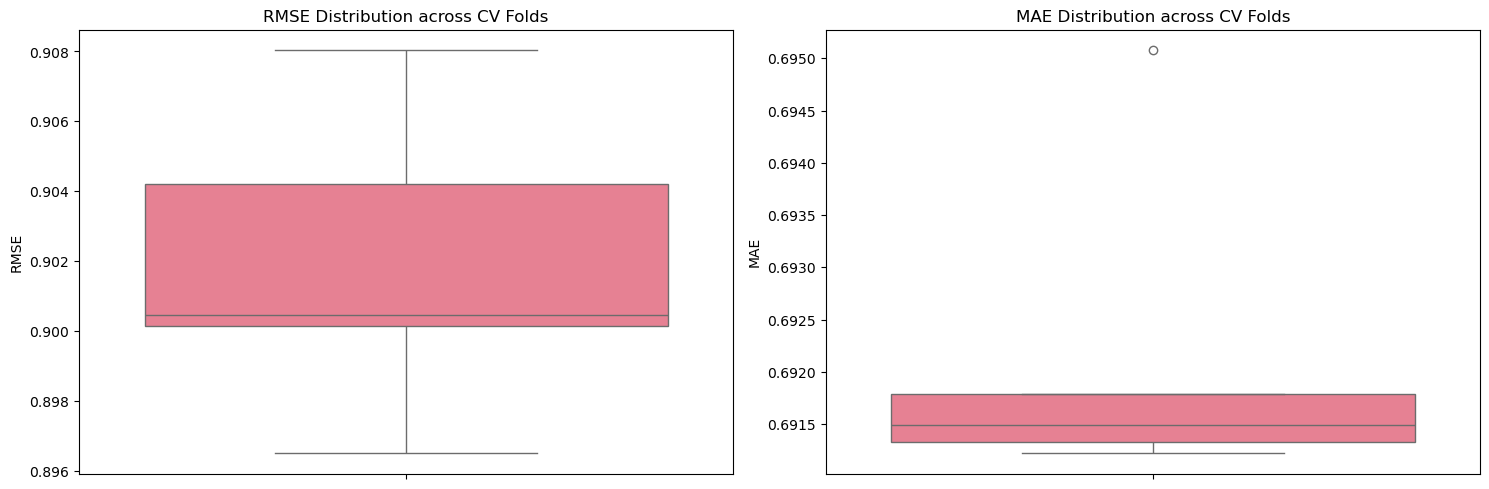


Average RMSE: 0.9019 (+/- 0.0039)
Average MAE: 0.6922 (+/- 0.0015)


In [13]:
def train_model(train_data, best_params):
    # Train the model with best parameters
    model = SVD(n_epochs=best_params['n_epochs'],
                lr_all=best_params['lr_all'],
                reg_all=best_params['reg_all'])
    
    # Perform cross-validation and plot results
    cv_results = cross_validate(model, train_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    plot_cv_results(cv_results)
    
    # Build the full trainset and train
    trainset = train_data.build_full_trainset()
    model.fit(trainset)
    
    return model

def plot_cv_results(cv_results):
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot RMSE distribution
    sns.boxplot(data=cv_results['test_rmse'], ax=ax1)
    ax1.set_title('RMSE Distribution across CV Folds')
    ax1.set_ylabel('RMSE')
    
    # Plot MAE distribution
    sns.boxplot(data=cv_results['test_mae'], ax=ax2)
    ax2.set_title('MAE Distribution across CV Folds')
    ax2.set_ylabel('MAE')
    
    plt.tight_layout()
    plt.show()
    
    # Print average metrics
    print(f"\nAverage RMSE: {np.mean(cv_results['test_rmse']):.4f} (+/- {np.std(cv_results['test_rmse']):.4f})")
    print(f"Average MAE: {np.mean(cv_results['test_mae']):.4f} (+/- {np.std(cv_results['test_mae']):.4f})")

# Train the model
model = train_model(train_data, best_params)

## 5. Make Predictions

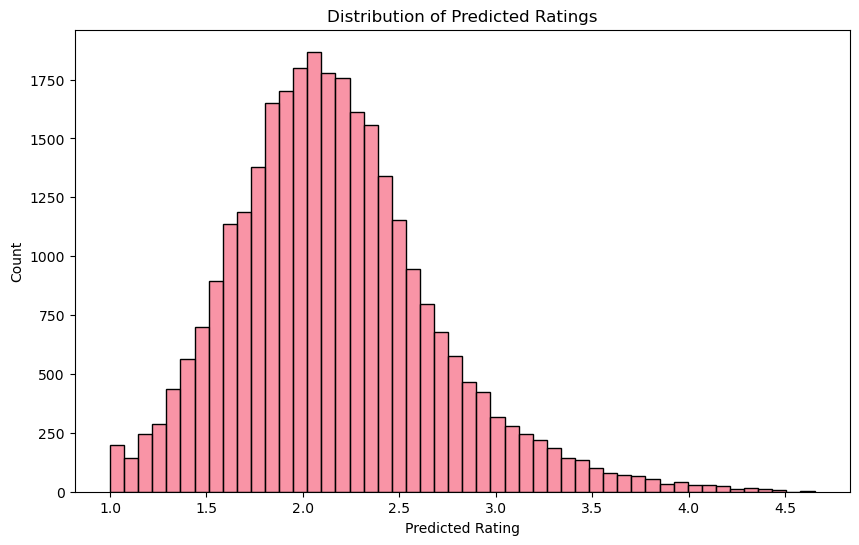


Prediction Statistics:
count    29367.000000
mean         2.162586
std          0.525295
min          1.000000
25%          1.810540
50%          2.114663
75%          2.446559
max          4.651354
dtype: float64

Predictions saved to 'predictions.csv'


In [14]:
def predict_ratings(model, test_df):
    # Make predictions
    predictions = []
    for _, row in test_df.iterrows():
        pred = model.predict(row['user_id'], row['book_id'])
        predictions.append(pred.est)
    
    # Create submission dataframe
    submission_df = test_df[['id']].copy()
    submission_df['rating'] = predictions
    
    # Plot prediction distribution
    plot_prediction_distribution(predictions)
    
    return submission_df

def plot_prediction_distribution(predictions):
    plt.figure(figsize=(10, 6))
    sns.histplot(predictions, bins=50)
    plt.title('Distribution of Predicted Ratings')
    plt.xlabel('Predicted Rating')
    plt.ylabel('Count')
    plt.show()
    
    # Print prediction statistics
    print("\nPrediction Statistics:")
    print(pd.Series(predictions).describe())

# Make predictions
predictions_df = predict_ratings(model, test_df)

# Save predictions
predictions_df.to_csv('predictions.csv', index=False)
print("\nPredictions saved to 'predictions.csv'")